In [31]:
import os
from PIL import Image

def downsample_image(image, scale_factor):

    width, height = image.size
    new_size = (width // scale_factor, height // scale_factor)
    downsampled_image = image.resize(new_size, Image.BICUBIC)

    low_quality_image = downsampled_image.resize((width, height), Image.BICUBIC)
    return low_quality_image


def prepare_data(hr_image_dir, lr_image_dir, scale_factor=2):
    if not os.path.exists(lr_image_dir):
        os.makedirs(lr_image_dir)
    hr_images = os.listdir(hr_image_dir)
    for img_name in hr_images:
        hr_image_path = os.path.join(hr_image_dir, img_name)
        lr_image_path = os.path.join(lr_image_dir, img_name)

        hr_image = Image.open(hr_image_path).convert('RGB')
        lr_image = downsample_image(hr_image, scale_factor)
        lr_image.save(lr_image_path)


In [32]:
prepare_data('./data/high_res', './data/low_res', scale_factor=2)

In [33]:
import torch
import torch.nn as nn

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.layer1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.layer2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.layer3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

model = SRCNN()


In [35]:
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [36]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

class SRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir):
        self.lr_images = sorted([os.path.join(lr_dir, x) for x in os.listdir(lr_dir)])
        self.hr_images = sorted([os.path.join(hr_dir, x) for x in os.listdir(hr_dir)])
        self.to_tensor = ToTensor()

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, idx):
        lr_image = Image.open(self.lr_images[idx]).convert('RGB')
        hr_image = Image.open(self.hr_images[idx]).convert('RGB')
        lr_image = self.to_tensor(lr_image)
        hr_image = self.to_tensor(hr_image)
        return lr_image, hr_image


In [37]:
from torch.utils.data import random_split
import os

batch_size = 16
train_dataset = SRDataset('./data/low_res', './data/high_res')

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [38]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):

        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [39]:
def train_model(model, num_epochs, minimum_delta):
    early_stopping = EarlyStopping(patience=10, min_delta=minimum_delta)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for lr_imgs, hr_imgs in train_loader:
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)

            optimizer.zero_grad()
            sr_imgs = model(lr_imgs)
            loss = criterion(sr_imgs, hr_imgs)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for lr_imgs, hr_imgs in val_loader:
                lr_imgs = lr_imgs.to(device)
                hr_imgs = hr_imgs.to(device)
                sr_imgs = model(lr_imgs)
                loss = criterion(sr_imgs, hr_imgs)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        early_stopping(avg_val_loss)

        if early_stopping.early_stop:
            print("Early stopping triggered. Stopping training.")
            break


In [40]:
train_model(model, 100, 0.0001)

Epoch [1/100], Train Loss: 0.1386, Val Loss: 0.0231
Epoch [2/100], Train Loss: 0.0192, Val Loss: 0.0147
Epoch [3/100], Train Loss: 0.0155, Val Loss: 0.0132
Epoch [4/100], Train Loss: 0.0132, Val Loss: 0.0109
Epoch [5/100], Train Loss: 0.0107, Val Loss: 0.0089
Epoch [6/100], Train Loss: 0.0089, Val Loss: 0.0075
Epoch [7/100], Train Loss: 0.0074, Val Loss: 0.0063
Epoch [8/100], Train Loss: 0.0062, Val Loss: 0.0052
Epoch [9/100], Train Loss: 0.0052, Val Loss: 0.0044
Epoch [10/100], Train Loss: 0.0044, Val Loss: 0.0038
Epoch [11/100], Train Loss: 0.0040, Val Loss: 0.0035
Epoch [12/100], Train Loss: 0.0037, Val Loss: 0.0033
Epoch [13/100], Train Loss: 0.0034, Val Loss: 0.0031
Epoch [14/100], Train Loss: 0.0032, Val Loss: 0.0029
Epoch [16/100], Train Loss: 0.0029, Val Loss: 0.0026
Epoch [17/100], Train Loss: 0.0027, Val Loss: 0.0025
Epoch [18/100], Train Loss: 0.0026, Val Loss: 0.0024
Epoch [19/100], Train Loss: 0.0025, Val Loss: 0.0022
Epoch [20/100], Train Loss: 0.0023, Val Loss: 0.0021
Ep

In [41]:
torch.save(model.state_dict(), './super_res_model_state_dict1.pth')

In [42]:
import matplotlib.pyplot as plt

def display_images(lr_image, sr_image, hr_image=None):
    plt.figure(figsize=(15, 5))
    # Low-Resolution Image
    plt.subplot(1, 3, 1)
    plt.imshow(lr_image)
    plt.title('Low Resolution')
    plt.axis('off')
    # Super-Resolution Image
    plt.subplot(1, 3, 2)
    plt.imshow(sr_image)
    plt.title('Super Resolution')
    plt.axis('off')
    # High-Resolution Image
    if hr_image is not None:
        plt.subplot(1, 3, 3)
        plt.imshow(hr_image)
        plt.title('High Resolution (Ground Truth)')
        plt.axis('off')
    plt.show()

In [43]:
from math import log10
import torch.nn.functional as F
import numpy as np
from skimage import metrics

def psnr(sr, hr):
    mse = F.mse_loss(sr, hr)
    if mse == 0:
        return float('inf')
    return 20 * log10(1.0 / torch.sqrt(mse))

loss_values = []
psnr_values = []

def evaluate_images(model, lr_image_dir, hr_image_dir, num_images=15):

    lr_images = sorted(os.listdir(lr_image_dir))[:num_images]
    hr_images = sorted(os.listdir(hr_image_dir))[:num_images]

    for i, (lr_img_name, hr_img_name) in enumerate(zip(lr_images, hr_images)):
        lr_image_path = os.path.join(lr_image_dir, lr_img_name)
        hr_image_path = os.path.join(hr_image_dir, hr_img_name)
        lr_image = Image.open(lr_image_path).convert('RGB')
        hr_image = Image.open(hr_image_path).convert('RGB')

        lr_tensor = ToTensor()(lr_image).unsqueeze(0).to(device)
        with torch.no_grad():
            sr_tensor = model(lr_tensor)
        sr_image = sr_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()
        sr_image = np.clip(sr_image, 0, 1)

        hr_tensor = ToTensor()(hr_image).unsqueeze(0).to(device)
        psnr_value = psnr(sr_tensor, hr_tensor)
        psnr_values.append(psnr_value)

        loss = criterion(sr_tensor, hr_tensor)
        loss_values.append(loss.item())

        display_images(lr_image, sr_image, hr_image)

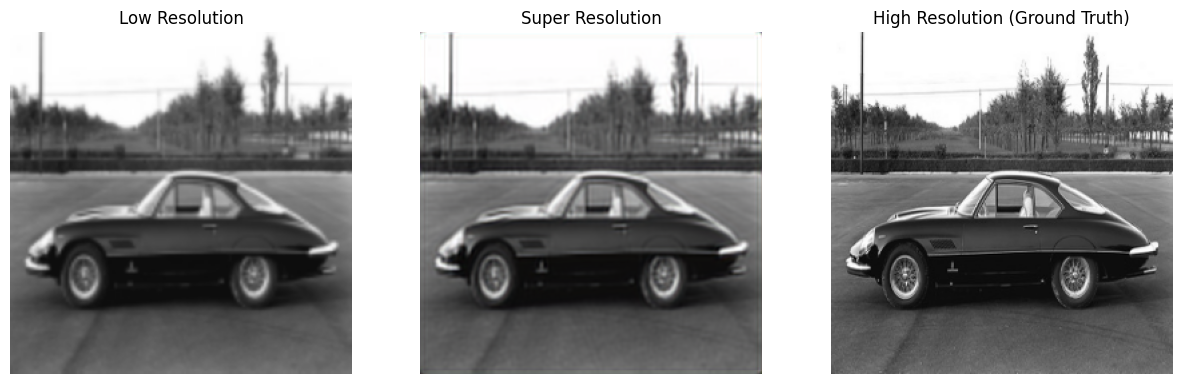

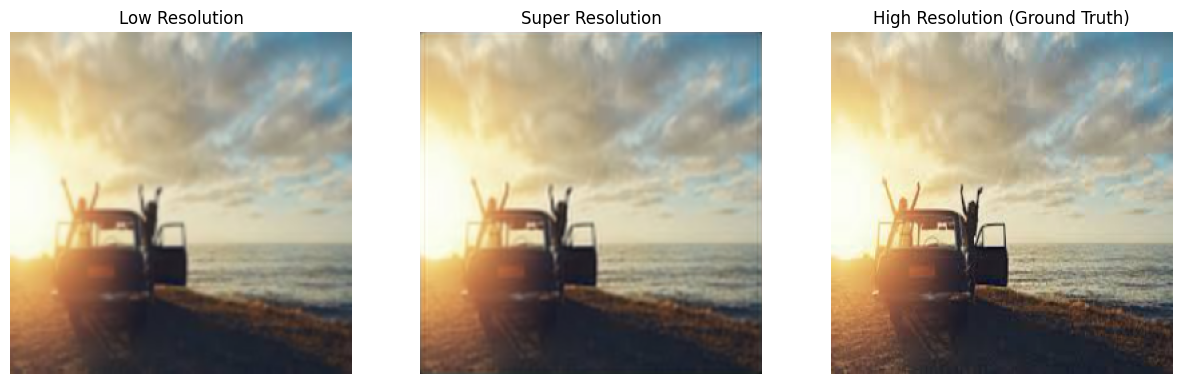

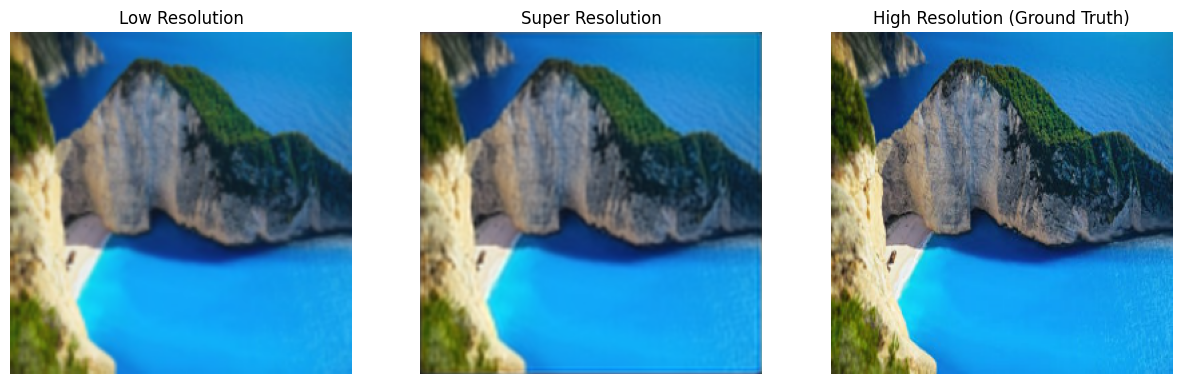

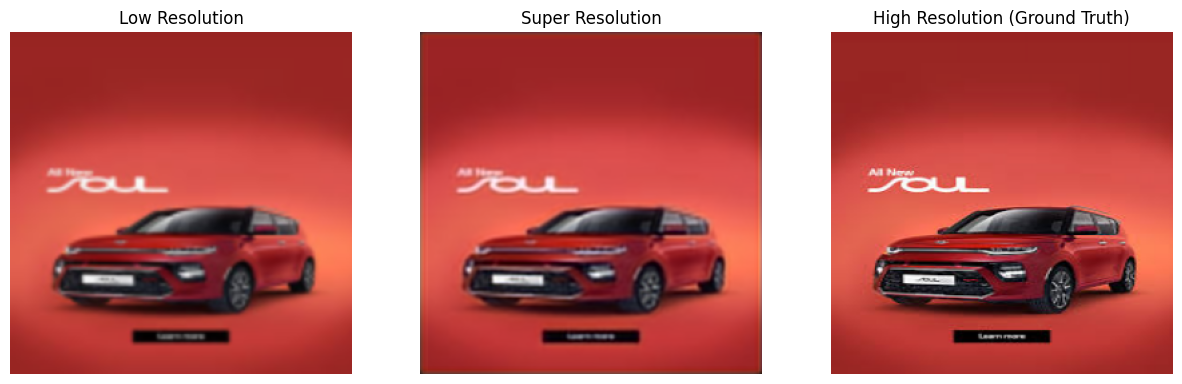

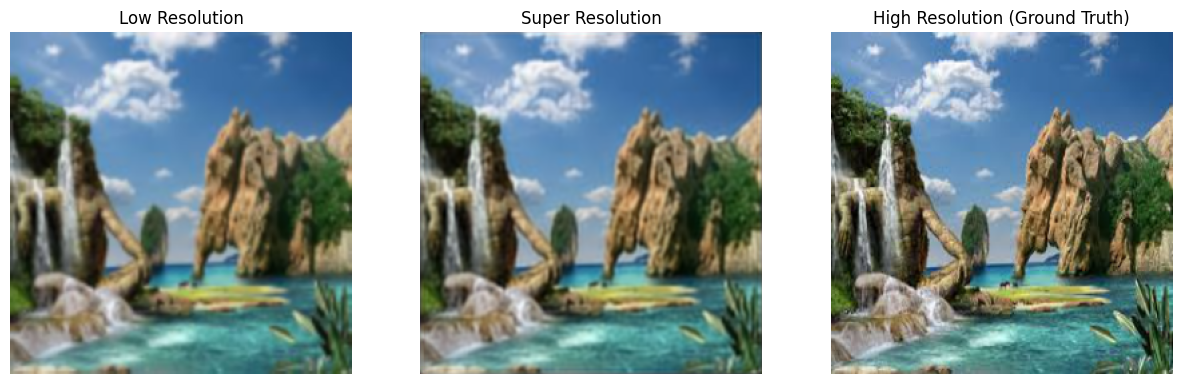

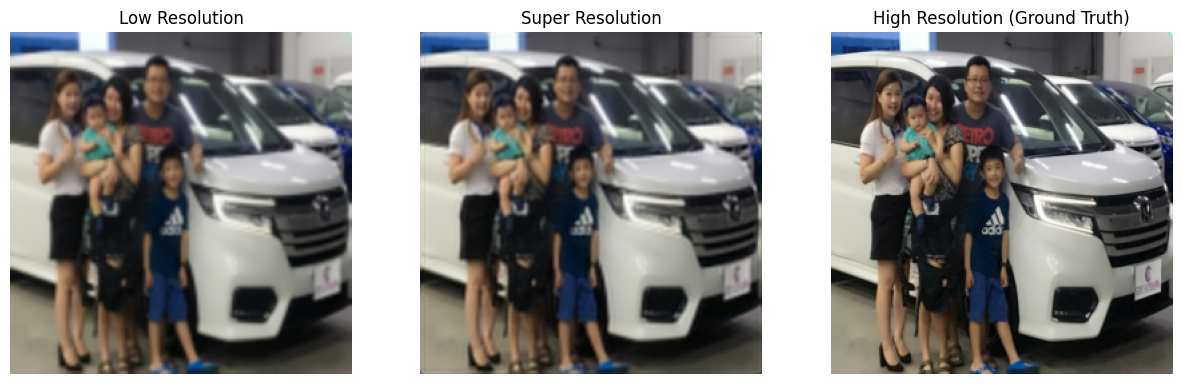

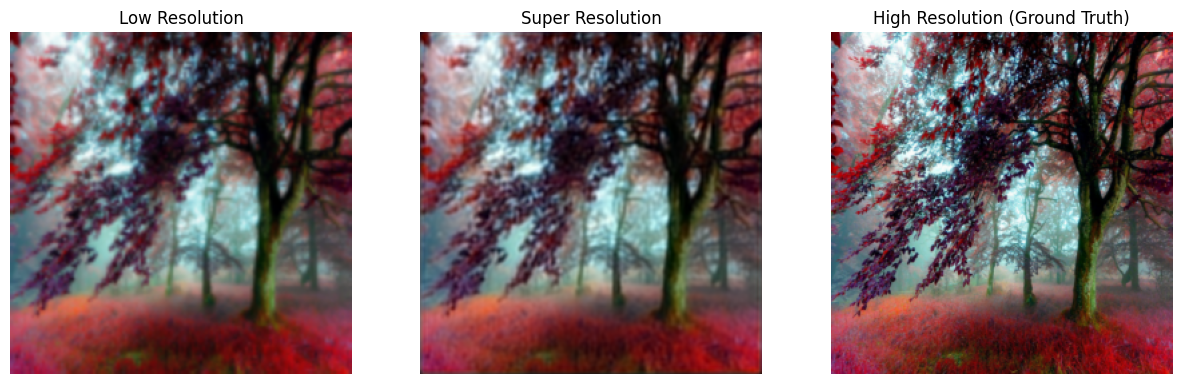

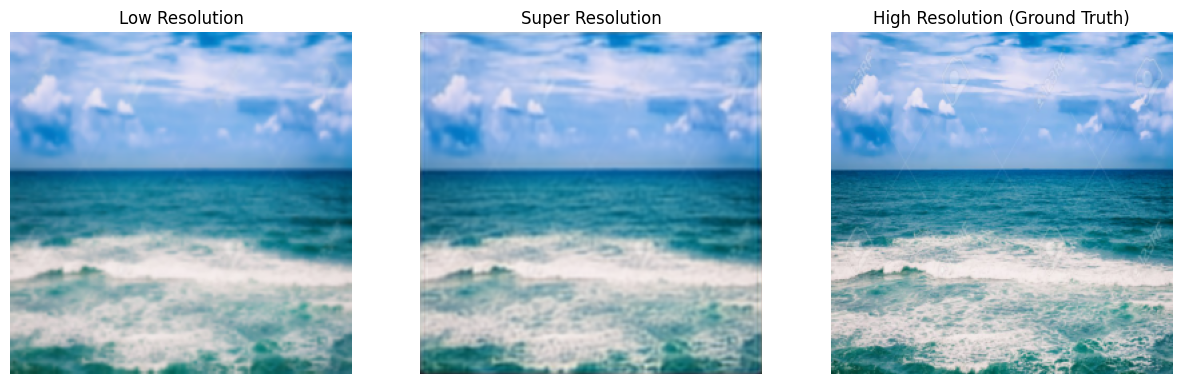

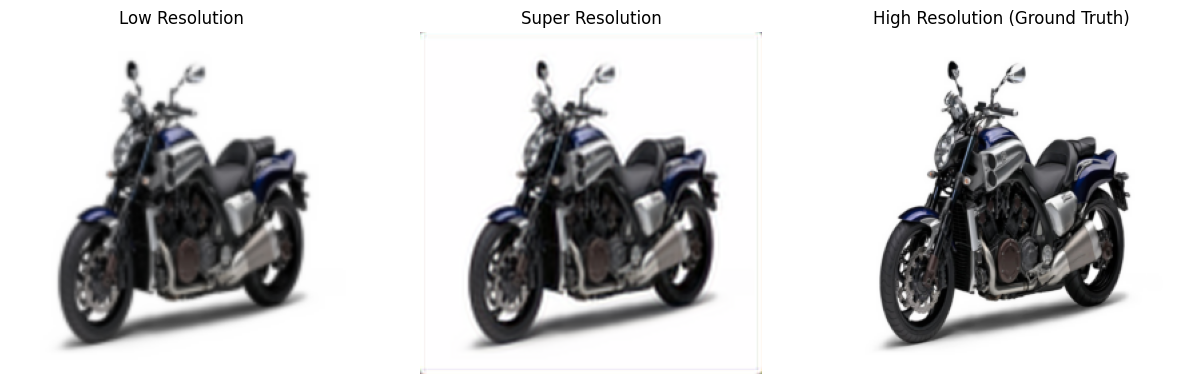

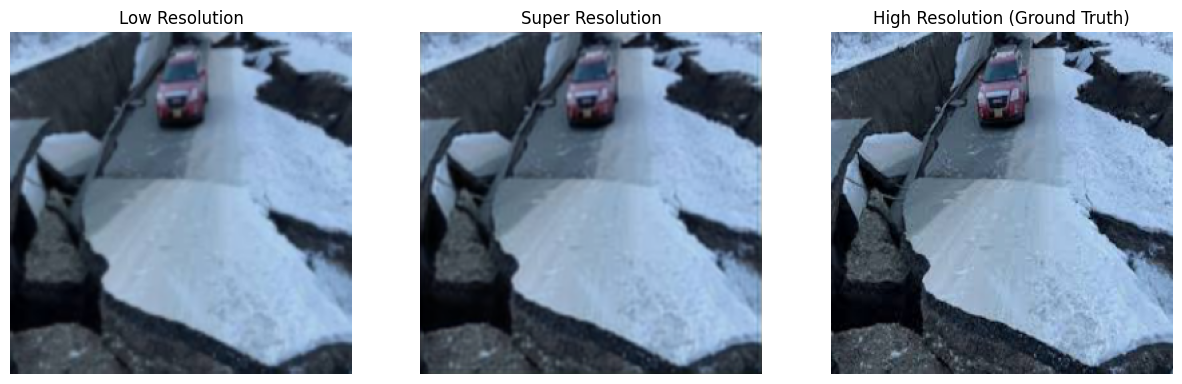

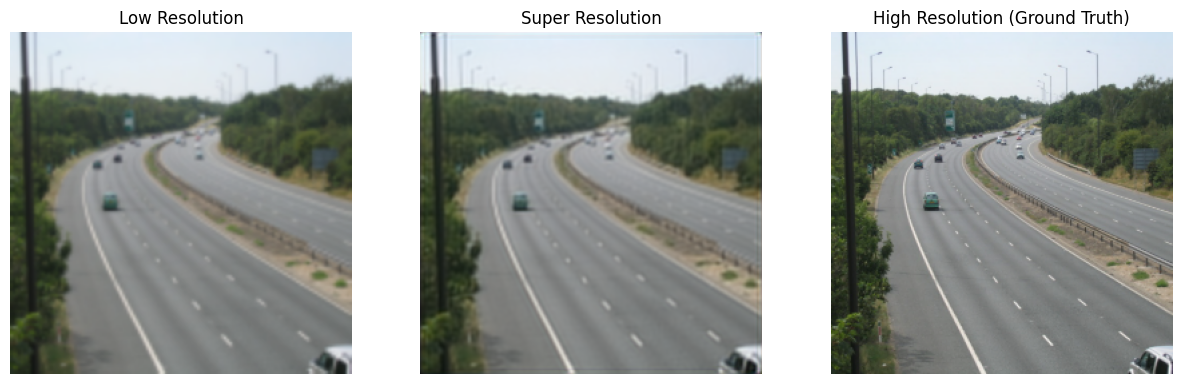

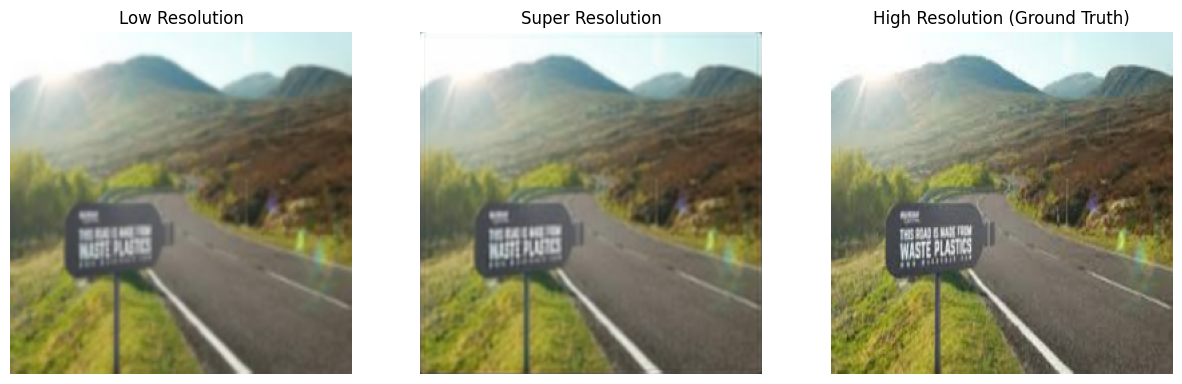

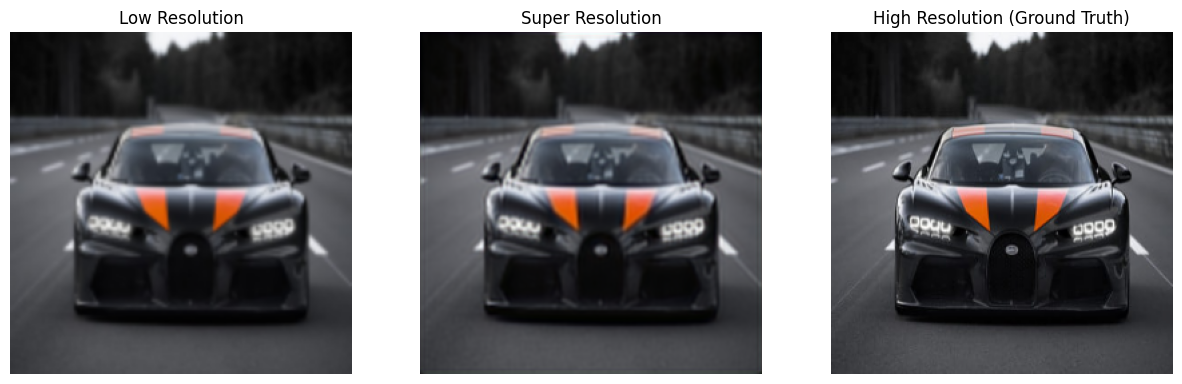

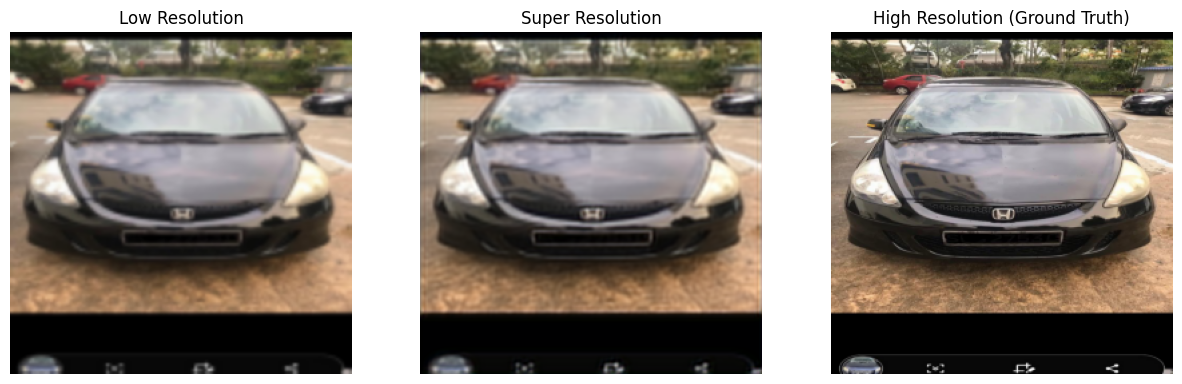

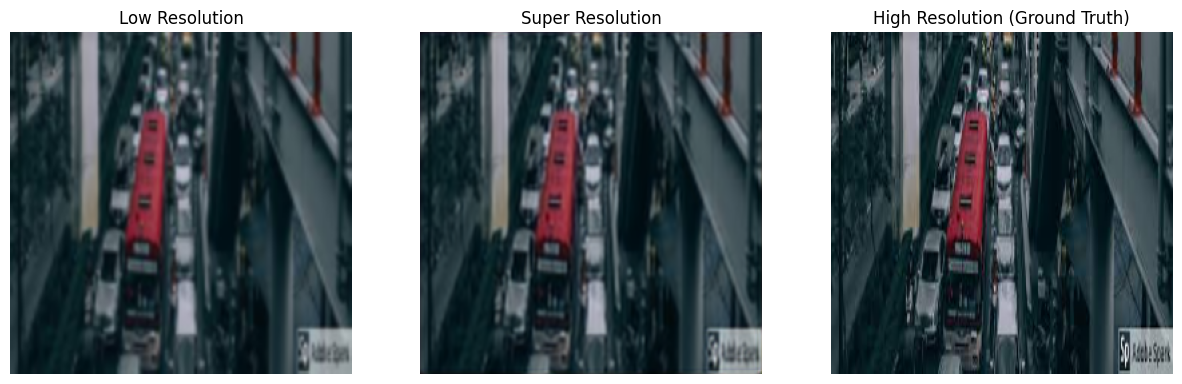

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
evaluate_images(model, './data/test/low_res_test', './data/test/high_res_test')

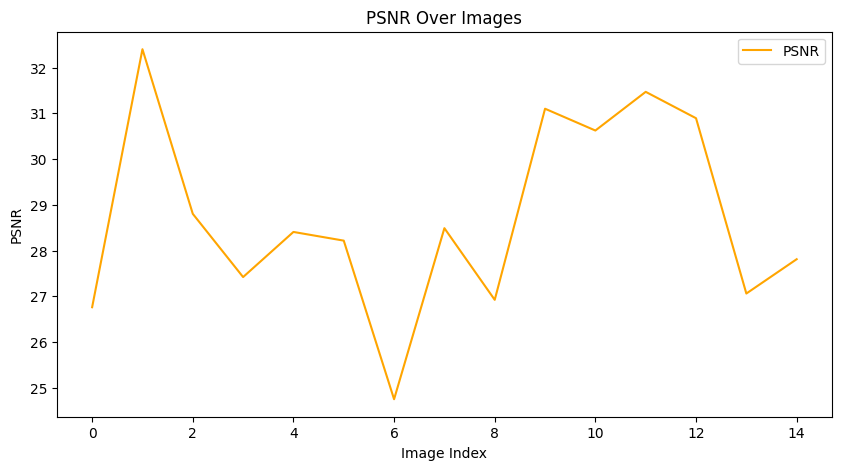

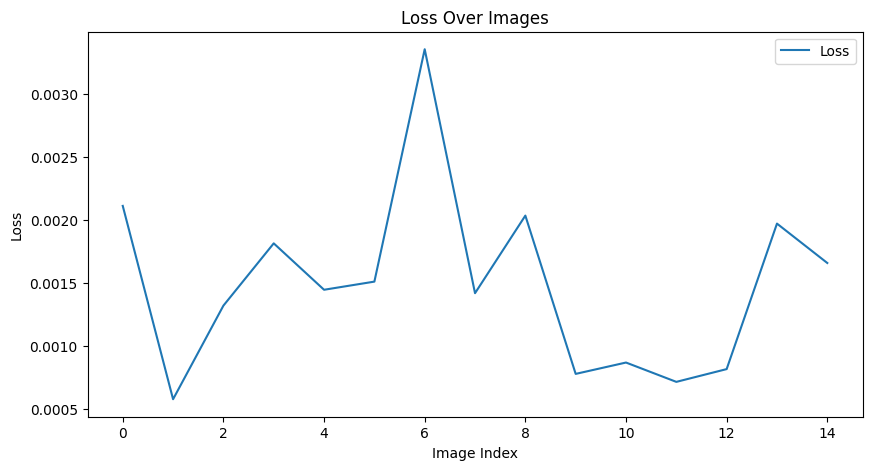

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(psnr_values, label='PSNR', color='orange')
plt.title('PSNR Over Images')
plt.xlabel('Image Index')
plt.ylabel('PSNR')
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Loss')
plt.title('Loss Over Images')
plt.xlabel('Image Index')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [46]:
from torchvision import transforms

def super_resolve_image(model, lr_image_path, output_path):
    model.eval()
    lr_image = Image.open(lr_image_path).convert('RGB')
    to_tensor = ToTensor()
    lr_image_tensor = to_tensor(lr_image).unsqueeze(0).to(device)

    with torch.no_grad():
        sr_image_tensor = model(lr_image_tensor)

    sr_image = sr_image_tensor.squeeze(0).cpu()
    sr_image = torch.clamp(sr_image, 0.0, 1.0)
    to_pil = transforms.ToPILImage()
    sr_image = to_pil(sr_image)
    sr_image.save(output_path)


In [47]:
super_resolve_image(model, './test_data/test.jpg', './test_sr.jpg')


FileNotFoundError: [Errno 2] No such file or directory: '/content/test_data/test.jpg'